<a href="https://colab.research.google.com/github/vinayhpandya/onefourthlabscode/blob/master/crnn_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import random
import time
import copy
import math

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim.lr_scheduler as lrs

import torchvision.utils as utils
import torchvision.datasets as dset
import torchvision.transforms as T
import torchvision.models as models

In [2]:
!git clone --recursive https://github.com/StickCui/warp-ctc-pytorch.git

Cloning into 'warp-ctc-pytorch'...
remote: Enumerating objects: 41, done.
remote: Total 41 (delta 0), reused 0 (delta 0), pack-reused 41
Unpacking objects: 100% (41/41), done.
Submodule 'warpctc/core' (https://github.com/baidu-research/warp-ctc) registered for path 'warpctc/core'
Cloning into '/content/warp-ctc-pytorch/warpctc/core'...
remote: Enumerating objects: 13, done.        
remote: Counting objects: 100% (13/13), done.        
remote: Compressing objects: 100% (12/12), done.        
remote: Total 437 (delta 1), reused 5 (delta 0), pack-reused 424        
Receiving objects: 100% (437/437), 334.57 KiB | 4.13 MiB/s, done.
Resolving deltas: 100% (206/206), done.
Submodule path 'warpctc/core': checked out '6d5b8fac130638862d97dc48ef43a8d7b5a503bb'


In [3]:
%cd warp-ctc-pytorch
!sh make.sh install

/content/warp-ctc-pytorch
/content/warp-ctc-pytorch
Make core shared object of libwarp_ctc.so
-- The C compiler identification is GNU 7.4.0
-- The CXX compiler identification is GNU 7.4.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Looking for pthread.h
-- Looking for pthread.h - found
-- Looking for pthread_create
-- Looking for pthread_create - not found
-- Looking for pthread_create in pthreads
-- Looking for pthread_create in pthreads - not found
-- Looking for pthread_create in pthread
-- Looking for pthread_create in pthread - fo

In [0]:
vgg16 = models.vgg16(pretrained=True)

In [5]:
from setuptools import find_packages
find_packages()

['warpctc']

In [47]:
hindi_alphabets = ['-']+[chr(alpha) for alpha in range(2304, 2432)]
hindi_alphabet_size = len(hindi_alphabets)
indexTochr={}
hindi_alpha2index={}
cnt=0
for alpha in hindi_alphabets:
    hindi_alpha2index[alpha] = cnt
    indexTochr[cnt]=alpha
    cnt+=1
print(hindi_alpha2index)
vocab_size=cnt
batch_size=16
sequence_len=28
RNN_input_dim=7168
RNN_hidden_dim=256
RNN_layer=2
RNN_type='LSTM'
RNN_dropout=0
use_VGG_extractor=False
learning_rate=(4e-3)*(0.8**0)

{'-': 0, 'ऀ': 1, 'ँ': 2, 'ं': 3, 'ः': 4, 'ऄ': 5, 'अ': 6, 'आ': 7, 'इ': 8, 'ई': 9, 'उ': 10, 'ऊ': 11, 'ऋ': 12, 'ऌ': 13, 'ऍ': 14, 'ऎ': 15, 'ए': 16, 'ऐ': 17, 'ऑ': 18, 'ऒ': 19, 'ओ': 20, 'औ': 21, 'क': 22, 'ख': 23, 'ग': 24, 'घ': 25, 'ङ': 26, 'च': 27, 'छ': 28, 'ज': 29, 'झ': 30, 'ञ': 31, 'ट': 32, 'ठ': 33, 'ड': 34, 'ढ': 35, 'ण': 36, 'त': 37, 'थ': 38, 'द': 39, 'ध': 40, 'न': 41, 'ऩ': 42, 'प': 43, 'फ': 44, 'ब': 45, 'भ': 46, 'म': 47, 'य': 48, 'र': 49, 'ऱ': 50, 'ल': 51, 'ळ': 52, 'ऴ': 53, 'व': 54, 'श': 55, 'ष': 56, 'स': 57, 'ह': 58, 'ऺ': 59, 'ऻ': 60, '़': 61, 'ऽ': 62, 'ा': 63, 'ि': 64, 'ी': 65, 'ु': 66, 'ू': 67, 'ृ': 68, 'ॄ': 69, 'ॅ': 70, 'ॆ': 71, 'े': 72, 'ै': 73, 'ॉ': 74, 'ॊ': 75, 'ो': 76, 'ौ': 77, '्': 78, 'ॎ': 79, 'ॏ': 80, 'ॐ': 81, '॑': 82, '॒': 83, '॓': 84, '॔': 85, 'ॕ': 86, 'ॖ': 87, 'ॗ': 88, 'क़': 89, 'ख़': 90, 'ग़': 91, 'ज़': 92, 'ड़': 93, 'ढ़': 94, 'फ़': 95, 'य़': 96, 'ॠ': 97, 'ॡ': 98, 'ॢ': 99, 'ॣ': 100, '।': 101, '॥': 102, '०': 103, '१': 104, '२': 105, '३': 106, '४': 107, '५': 108, '६': 109, '७': 110,

In [0]:
num_train=1600
train_indices=range(num_train)
num_test=3000

mytransform = T.Compose(
    [
        T.Resize((224,224)),
        T.ToTensor(),
        T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

In [0]:
from torch.utils.data import DataLoader, Dataset, random_split

In [0]:
import os
from PIL import Image

In [0]:
class CroppedDataset(Dataset):
  def __init__(self,transform,image_dir,annotate_dir):
    self.transform=transform
    self.img_path=[]
    self.img=[]
    self.word=[]
    for file in os.listdir(image_dir):
      self.img.append(file)
    with open(annotate_dir) as f:
      data=f.readlines()
    for k in data:
      #print(k.split("\t"))
      self.img_path.append(k.split("\t")[0])
      self.word.append(k.split("\t")[1])
  def __len__(self):
    return len(self.img)
  def __getitem__(self,indx):
    #print(self.word[indx])
    #print(self.img[indx])
    image=Image.open("cropped_data/"+''.join(self.img_path[indx])).convert("RGB")
    word=self.word[indx]
    return (self.transform(image),word)

In [11]:
#%cd ./warp-ctc-pytorch
!sh make.sh core
!python3 setup.py build_ext --inplace

/content/warp-ctc-pytorch
Make core shared object of libwarp_ctc.so
-- cuda found TRUE
CMake Warning at CMakeLists.txt:48 (FIND_PACKAGE):
  By not providing "FindTorch.cmake" in CMAKE_MODULE_PATH this project has
  asked CMake to find a package configuration file provided by "Torch", but
  CMake did not find one.

  Could not find a package configuration file provided by "Torch" with any of
  the following names:

    TorchConfig.cmake
    torch-config.cmake

  Add the installation prefix of "Torch" to CMAKE_PREFIX_PATH or set
  "Torch_DIR" to a directory containing one of the above files.  If "Torch"
  provides a separate development package or SDK, be sure it has been
  installed.


-- Torch found Torch_DIR-NOTFOUND
-- Building shared library with GPU support
-- Configuring done
-- Generating done
-- Build files have been written to: /content/warp-ctc-pytorch/warpctc/core/build
[ 14%] Linking CXX shared library libwarpctc.so
[ 42%] Built target warpctc
[ 57%] Linking CXX executable t

In [12]:
!ls
from setuptools import find_packages
find_packages()

build  check_ctc.py  LICENSE  make.sh  README.md  setup.py  warpctc


['warpctc']

In [0]:
from warpctc import CTCLoss
#!unzip cropped_data.zip

In [0]:
IIIT5K_train = CroppedDataset(mytransform,"cropped_data/cropped_dir","cropped_data/annotations.txt")
loader_train = DataLoader(dataset = IIIT5K_train,batch_size =16,sampler=SubsetRandomSampler(range(1600)))
loader_test = DataLoader(dataset = IIIT5K_train,batch_size = 1,shuffle=True)

In [54]:
len(loader_train)

100

('पी', 'रेल', 'विश्वकर्मा', 'परिसर', 'की', 'प्रथम', 'मल्टीकलर', 'स्वच्छ', 'रेल', 'स्टाम्प', 'सोनू', 'बालाजी', 'स्टोर्स', 'लो', 'स्टेशन', 'सी')


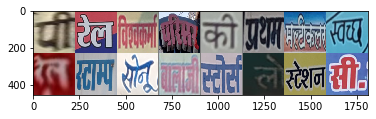

पी रेल विश्वकर्मा परिसर की प्रथम मल्टीकलर स्वच्छ रेल स्टाम्प सोनू बालाजी स्टोर्स लो स्टेशन सी


In [55]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(loader_train)
images,labels=dataiter.next()
#print(images)
print(labels)

imshow(utils.make_grid(images))
print(' '.join('%s' % labels[j] for j in range(batch_size)))

In [56]:
print('CUDA available :',torch.cuda.is_available())
cpu_dtype = torch.FloatTensor # the CPU datatype
gpu_dtype = torch.cuda.FloatTensor # the GPU datatype

dtype=gpu_dtype
print(dtype)

# From torchvision/vgg.py
def reset(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            nn.init.xavier_normal_(m.weight, gain=1)
#             n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
#             m.weight.data.normal_(0, math.sqrt(2. / n))
            if m.bias is not None:
                m.bias.data.zero_()
        elif isinstance(m, nn.BatchNorm2d):
            m.weight.data.fill_(1)
            m.bias.data.zero_()
        elif isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight, gain=1)
#             m.weight.data.normal_(0, 0.01)
            m.bias.data.zero_()
        elif hasattr(m, 'reset_parameters'):
            m.reset_parameters()
            
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1) 

CUDA available : True
<class 'torch.cuda.FloatTensor'>


In [0]:
class CNN_block(nn.Module):
    def __init__(self,in_channel,out_channel):
        super(CNN_block, self).__init__()
        self.conv_1=nn.Conv2d(in_channel, out_channel, kernel_size=3, stride=1, padding=1)
        self.conv_2=nn.Conv2d(out_channel, out_channel, kernel_size=3, stride=1, padding=1)
        self.conv_3=nn.Conv2d(out_channel, out_channel, kernel_size=3, stride=1, padding=1)
        self.batchnorm1=nn.BatchNorm2d(num_features=out_channel)
        self.batchnorm2=nn.BatchNorm2d(num_features=out_channel)
        self.batchnorm3=nn.BatchNorm2d(num_features=out_channel)
        self.relu=nn.ReLU(True)
        self.maxpool=nn.MaxPool2d(kernel_size=(2,2),stride=(2,2))
        
    def forward(self, x):
        x=self.relu(self.batchnorm1(self.conv_1(x)))
        x=self.relu(self.batchnorm2(self.conv_2(x)))
        x=self.relu(self.batchnorm3(self.conv_3(x)))
        x=self.maxpool(x)
        return x
    
class ToRNN(nn.Module):
    def forward(self, x):
        x=x.permute(3,0,1,2)
        W,N,C,H= x.size()
        x.contiguous()
        return x.view(W,N,-1)
    
class BiDireRNN(nn.Module):
    def __init__(self):
        super(BiDireRNN, self).__init__()
        self.hidden_dim = RNN_hidden_dim
        self.num_layers=RNN_layer
        self.sql=sequence_len
        self.bsize=batch_size
        self.dropout=RNN_dropout
        self.rnn_type=RNN_type
        self.rnn = self.rnn_layer()
        self.hidden=None
        self.init_hidden(batch_size)
        
    def rnn_layer(self):
        if self.rnn_type=='RNN':
            return nn.RNN(RNN_input_dim, self.hidden_dim, self.num_layers, dropout=self.dropout, bidirectional=True)
        elif self.rnn_type=='LSTM':
            return nn.LSTM(RNN_input_dim, self.hidden_dim, self.num_layers, dropout=0.7, bidirectional=True)
        elif self.rnn_type=='GRU':
            return nn.GRU(RNN_input_dim, self.hidden_dim, self.num_layers, dropout=self.dropout, bidirectional=True)
        else:
            raise AssertionError('unknown RNN type:',self.rnn_type)
    
    def init_hidden(self,bsize):
        if self.rnn_type=='LSTM':
            self.hidden=(Variable(torch.zeros(self.num_layers*2, bsize, self.hidden_dim).type(dtype)),
                    Variable(torch.zeros(self.num_layers*2, bsize, self.hidden_dim).type(dtype)))
        else:
            self.hidden=Variable(torch.zeros(self.num_layers*2, bsize, self.hidden_dim))
        
    
    def forward(self, x):
      rnn_out, self.hidden = self.rnn(x, self.hidden)
      return rnn_out
        

class Model(nn.Module):
    def __init__(self,use_VGG_extractor=False):
        super(Model, self).__init__()
        if use_VGG_extractor:
            self.feature_extractor=nn.Sequential(*([vgg16.features[i] for i in range(17)]))
            for param in self.feature_extractor.parameters():
                param.requires_grad=False
                
        else:
            self.feature_extractor=nn.Sequential(*([CNN_block(3,64),CNN_block(64,128),CNN_block(128,256)]))
        self.toRNN=ToRNN()
        self.RNN=BiDireRNN()
        self.toTraget=nn.Linear(RNN_hidden_dim*2, vocab_size)
        self.softmax=nn.Softmax(dim=2)

    def forward(self, x):
        feature=self.feature_extractor(x)
        RNN_input=self.toRNN(feature)
        RNN_out=self.RNN(RNN_input)
        tag_scores = self.toTraget(RNN_out)
        #tag_scores=self.softmax(tag_scores)
        return tag_scores

In [93]:
my_model=Model(use_VGG_extractor=True).type(dtype)
print(my_model)
for param in my_model.named_parameters():
    print(param[0],type(param[1].data),param[1].size(),param[1].requires_grad)

Model(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0,

In [0]:
import torch
loss_function = torch.nn.CTCLoss().type(dtype)
# opt_parameters=my_model.parameters() if use_VGG_extractor==False else [my_model.RNN.parameters(),my_model.toTraget.parameters()]
# print(opt_parameters)
# optimizer = optim.Adam(opt_parameters, lr=4e-3)

if use_VGG_extractor:
    opt_parameters=list(my_model.RNN.parameters())+list(my_model.toTraget.parameters())
    optimizer = optim.Adam(iter(opt_parameters), lr=0.004)
else:
    optimizer = optim.Adam(my_model.parameters(), lr=0.004)

scheduler = lrs.StepLR(optimizer, step_size=30, gamma=0.8)
softmax=torch.nn.LogSoftmax(dim=2)

In [95]:
print(type(loss_function))

<class 'torch.nn.modules.loss.CTCLoss'>


In [0]:
def model_train(max_epoch,print_every):

    iter_each_epoch=num_train//batch_size
    loss_his_train=[]

    for epoch in range(max_epoch):
        #scheduler.step()
        #my_model.train()
        print(time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())),
              'start epoch %d/%d:' % (epoch+1,max_epoch),'learning_rate =',scheduler.get_lr()[0],
              'sequence_len =',my_model.RNN.sql)
        tot_loss=0
        
        it=0
        for images,labels in loader_train:

            X_var=Variable(images.type(dtype))
            
            out_size=Variable(torch.IntTensor([sequence_len] * batch_size))
            y_size=Variable(torch.IntTensor([len(l) for l in labels]))
            conc_label=''.join(labels)
            #print(conc_label)
            y=[hindi_alpha2index[c] for c in conc_label]
            #print(y)
            #print(y_size)
            y_var=Variable(torch.IntTensor(y))

            my_model.zero_grad()

            my_model.RNN.init_hidden(batch_size)

            scores = my_model(X_var)

            loss = loss_function(softmax(scores),y_var,out_size,y_size)/batch_size
            loss.backward()
            torch.nn.utils.clip_grad_norm_(my_model.parameters(), 1)
            optimizer.step()
            
            tot_loss+=loss.item()
            
            if it==0 or (it+1)%print_every==0 or it==iter_each_epoch-1:
                print(time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())),
                      'iter %d loss = %f' % (it+1,loss.item()))
            it+=1
                
        tot_loss/=iter_each_epoch
        print(time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())),
                'epoch %d/%d average_loss = %f\n' % (epoch+1,max_epoch,tot_loss))
        loss_his_train.append(tot_loss)
    return loss_his_train

In [97]:
my_model.apply(reset)
# my_model.load_state_dict(torch.load('parameters-5000'))
#my_model.train()
my_model.RNN.init_hidden(batch_size)
loss_his_train=model_train(max_epoch=500,print_every=25)

2020-01-19 17:50:22 start epoch 1/500: learning_rate = 0.004 sequence_len = 28
2020-01-19 17:50:22 iter 1 loss = 1.935390
2020-01-19 17:50:25 iter 25 loss = 0.654149
2020-01-19 17:50:29 iter 50 loss = 0.908854
2020-01-19 17:50:32 iter 75 loss = 0.596117
2020-01-19 17:50:35 iter 100 loss = 0.514114
2020-01-19 17:50:35 epoch 1/500 average_loss = 0.695580

2020-01-19 17:50:35 start epoch 2/500: learning_rate = 0.004 sequence_len = 28
2020-01-19 17:50:35 iter 1 loss = 0.640003
2020-01-19 17:50:38 iter 25 loss = 0.749625
2020-01-19 17:50:41 iter 50 loss = 0.514240
2020-01-19 17:50:45 iter 75 loss = 0.584442
2020-01-19 17:50:48 iter 100 loss = 0.762727
2020-01-19 17:50:48 epoch 2/500 average_loss = 0.644802

2020-01-19 17:50:48 start epoch 3/500: learning_rate = 0.004 sequence_len = 28
2020-01-19 17:50:48 iter 1 loss = 0.596095
2020-01-19 17:50:51 iter 25 loss = 0.593271
2020-01-19 17:50:54 iter 50 loss = 0.501565
2020-01-19 17:50:57 iter 75 loss = 0.850079
2020-01-19 17:51:01 iter 100 loss 

In [0]:
torch.save(my_model.state_dict(),"weights_final.pth")

torch.Size([1, 3, 224, 224])


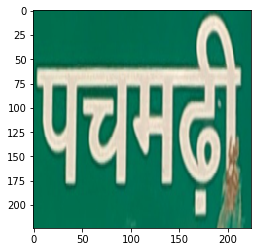

पचमढी
(1, 256, 28, 28)


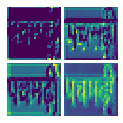

पचमढी


In [106]:
dataiter = iter(loader_train)
#my_model.load_state_dict(torch.load("/weights"))
#my_model.eval()
image_train, label_train = dataiter.next()
image_train=image_train[2,...].resize_([1]+list(image_train.size())[1:])
#new_image=Image.open("cropped_data/cropped_dir/10.jpg").convert("RGB")
#new_image=mytransform(new_image)
print(image_train.size())
#new_image=new_image.unsqueeze(0)
imshow(utils.make_grid(image_train))
print(label_train[2])

x_var_train = Variable(image_train.type(dtype))
out=my_model.feature_extractor(x_var_train)
feature_map=out.cpu().data.numpy()
print(feature_map.shape)
sample_index=np.random.choice(256,4)
plt.figure(figsize = (2,2))
gs1 = gridspec.GridSpec(2, 2)
gs1.update(wspace=0.025, hspace=0.05)

for i in range(4):
    plt.subplot(gs1[i])
    feature_submap=feature_map[0,sample_index[i],:,:]
    plt.imshow(feature_submap)
    plt.axis('off')
plt.show()

my_model.RNN.init_hidden(1)
result=my_model(x_var_train)
softmax=nn.Softmax(dim=2)
result_sf=softmax(result)
result_np=result_sf.cpu().data.numpy()
result_word=''
for i in range(sequence_len):
    ch=np.argmax(result_np[i,0,:])
    #print(ch)
    if indexTochr[ch] in result_word:
      continue
    result_word+=indexTochr[ch]
print(result_word.replace("-"," ").strip())